In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
keras.utils.set_random_seed(42)

In [3]:
img_paths = glob.glob("../dataset/train/*.jpg")
len(img_paths)

10000

(27, 48, 3)


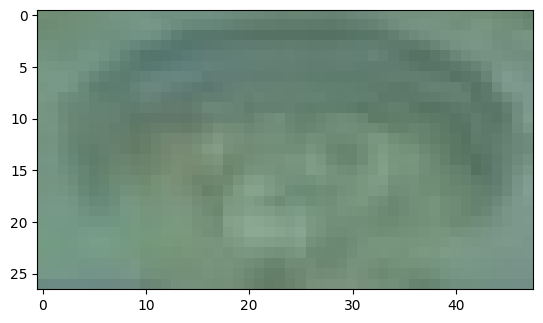

In [4]:
img = cv2.imread(img_paths[0])
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [5]:
X_train, X_test = train_test_split(img_paths, train_size=0.8, random_state=42)

In [6]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.image.resize(img,[48, 48])
    img = tf.cast(img, tf.float32)
    img = img/255
    
    return img

In [7]:
batch_size = 256

data_train = tf.data.Dataset.from_tensor_slices(X_train)
data_train = data_train.map(load_img)
dataset_train = tf.data.Dataset.zip((data_train, data_train))
print(len(dataset_train))

dataset_train = dataset_train.shuffle(500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

Metal device set to: Apple M1
8000


In [8]:
data_test = tf.data.Dataset.from_tensor_slices(X_test)
data_test = data_test.map(load_img)
dataset_test = tf.data.Dataset.zip((data_test, data_test))
print(len(dataset_test))

dataset_test = dataset_test.shuffle(500).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2000


In [9]:
def load_data(paths):
    data = []
    for path in paths:
        data.append(load_img(path))
    return np.asarray(data)

In [10]:
df_test = pd.read_csv("../dataset/test/test_annotation.txt", sep=' ', names = ['img_name', 'class'])
df_test['img_name'] = df_test['img_name'].apply(lambda x: "../dataset/test/imgs/"+x)
test_data = load_data(df_test['img_name'].to_list())
df_test

,img_name,class
0,../dataset/test/imgs/b9bc8d6d-0cb6-40c2-a38d-6...,0
1,../dataset/test/imgs/9d3893a3-c877-4873-81c5-9...,0
2,../dataset/test/imgs/4f5cef60-bf06-4daf-be8d-a...,0
3,../dataset/test/imgs/37ee27b2-89a3-4b66-98a4-f...,0
4,../dataset/test/imgs/43543d1a-24b6-4018-af56-2...,0
...,...,...
3789,../dataset/test/imgs/00bd95dc-4f01-404b-9f59-1...,0
3790,../dataset/test/imgs/09e62c5f-f3bf-4de2-bc76-2...,0
3791,../dataset/test/imgs/e92ab320-3577-424f-8c32-f...,0
3792,../dataset/test/imgs/db135776-bf7f-4450-83b9-5...,0


# Эксперимент 1

In [11]:
inputs = keras.Input(shape = (48, 48, 3))
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', strides=2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', strides=2)(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same', strides=2)(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same')(x)
x = keras.layers.UpSampling2D(2)(x)
outputs = keras.layers.Conv2D(3, (3, 3), padding='same', activation = 'sigmoid')(x)
model_1 = keras.Model(inputs, outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 128)         147584

In [12]:
model_1.compile(optimizer="Adam", loss="mse")

In [13]:
hist = model_1.fit(dataset_train, epochs = 5, validation_data=dataset_test, 
                   callbacks=tf.keras.callbacks.TensorBoard(log_dir='../logs/exp1'))

Epoch 1/5
32/32 [==============================] - 14s 416ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 2/5
32/32 [==============================] - 12s 359ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 3/5
32/32 [==============================] - 11s 356ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/5
32/32 [==============================] - 11s 355ms/step - loss: 0.0011 - val_loss: 7.6469e-04
Epoch 5/5
32/32 [==============================] - 14s 439ms/step - loss: 7.0912e-04 - val_loss: 8.3553e-04


In [14]:
model_1.evaluate(dataset_test)

8/8 [==============================] - 1s 129ms/step - loss: 8.3553e-04


0.0008355320314876735

<Axes: >

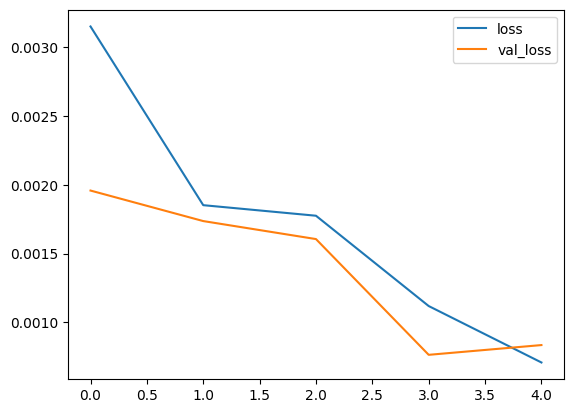

In [15]:
#График изменения функции потерь
history_df = pd.DataFrame(hist.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

1/1 [==============================] - 0s 143ms/step


[[], []]

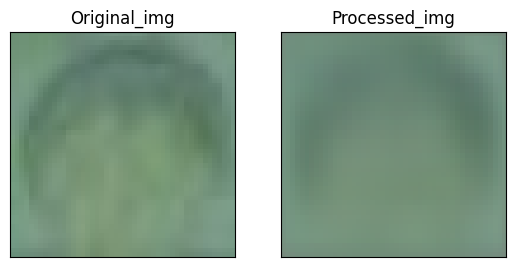

In [16]:
img = np.expand_dims(load_img(X_train[10]), axis=0)
res_img = model_1.predict(img)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img[0])
axs[0].set_title('Original_img')
axs[0].set(xticks=[], yticks=[])
axs[1].imshow(res_img[0])
axs[1].set_title('Processed_img')
axs[1].set(xticks=[], yticks=[])

In [17]:
proliv_paths = glob.glob("../dataset/proliv/*.jpg")
len(proliv_paths)

154

1/1 [==============================] - 0s 19ms/step
MSE = 0.0027002522256225348


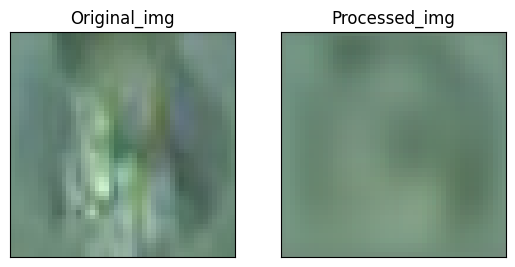

In [18]:
proliv_img = np.expand_dims(load_img(proliv_paths[130]), axis=0)
res_proliv = model_1.predict(proliv_img)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(proliv_img[0])
axs[0].set_title('Original_img')
axs[0].set(xticks=[], yticks=[])
axs[1].imshow(res_proliv[0])
axs[1].set_title('Processed_img')
axs[1].set(xticks=[], yticks=[])
print(f"MSE = {np.mean(np.square(proliv_img-res_proliv))}")

In [19]:
data_proliv = load_data(proliv_paths)
proliv_res = model_1.predict(data_proliv)

5/5 [==============================] - 0s 29ms/step


In [20]:
mse_list = []
for i in range(len(proliv_res)):
    mse_list.append(np.mean(np.square(data_proliv[i]-proliv_res[i])))
mse = np.mean(mse_list)
print(mse)

0.0031886918


In [21]:
preds = model_1.predict(test_data)

119/119 [==============================] - 2s 21ms/step


In [22]:
def get_preds(imgs, preds, threshold=1):
    labels = []
    for i in range(len(preds)):
        mse = np.mean(np.square(imgs[i]-preds[i]))
        if mse < 0.003*threshold:
            labels.append(0)
        else: 
            labels.append(1)
    return np.asarray(labels)

In [23]:
coef = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 1.1, 1.2, 1.4, 1.5, 1.6, 1.9, 2, 2.16]
for c in coef:
    tn, fp, fn, tp = confusion_matrix(df_test['class'], get_preds(test_data, preds, c)).ravel()
    print("TPR = {}, FPR = {}, threshold = {}, c = {}".format(tp/(tp+fn), tn/(tn+fp), c*0.003, c))

TPR = 0.9922480620155039, FPR = 0.9184174624829468, threshold = 0.0021, c = 0.7
TPR = 0.9922480620155039, FPR = 0.9304229195088677, threshold = 0.0022500000000000003, c = 0.75
TPR = 0.9689922480620154, FPR = 0.9377899045020464, threshold = 0.0024000000000000002, c = 0.8
TPR = 0.9302325581395349, FPR = 0.9489768076398363, threshold = 0.00255, c = 0.85
TPR = 0.8837209302325582, FPR = 0.9585266030013643, threshold = 0.0027, c = 0.9
TPR = 0.8604651162790697, FPR = 0.9653478854024556, threshold = 0.00285, c = 0.95
TPR = 0.8217054263565892, FPR = 0.9702592087312415, threshold = 0.003, c = 1
TPR = 0.7209302325581395, FPR = 0.976261937244202, threshold = 0.0033000000000000004, c = 1.1
TPR = 0.5891472868217055, FPR = 0.9787175989085948, threshold = 0.0036, c = 1.2
TPR = 0.4263565891472868, FPR = 0.9830832196452933, threshold = 0.0042, c = 1.4
TPR = 0.37209302325581395, FPR = 0.9839017735334242, threshold = 0.0045000000000000005, c = 1.5
TPR = 0.31007751937984496, FPR = 0.9860845839017736, thres

In [24]:
df_test['predicted'] = get_preds(test_data, preds, threshold=0.8)

In [25]:
tn, fp, fn, tp = confusion_matrix(df_test['class'], df_test['predicted']).ravel()
print("TPR = {}, FPR = {}, MSE_threshold = {}".format(tp/(tp+fn), tn/(tn+fp), 0.0016))

TPR = 0.9689922480620154, FPR = 0.9377899045020464, MSE_threshold = 0.0016


In [26]:
model_1.save("../Models/hw_2_first.keras")